Installing 'imbalanced-learn' for SMOTE...
Installation complete.

--- Phase 1: Data Collection & Understanding ---
Successfully loaded 'Diabetes Missing Data.csv'.

--- Initial Data Exploration ---

Data Head (First 5 Rows):
   Pregnant  Glucose  Diastolic_BP  Skin_Fold  Serum_Insulin   BMI  \
0         6    148.0          72.0       35.0            NaN  33.6   
1         1     85.0          66.0       29.0            NaN  26.6   
2         8    183.0          64.0        NaN            NaN  23.3   
3         1     89.0          66.0       23.0           94.0  28.1   
4         0    137.0          40.0       35.0          168.0  43.1   

   Diabetes_Pedigree  Age  Class  
0              0.627   50      1  
1              0.351   31      0  
2              0.672   32      1  
3              0.167   21      0  
4              2.288   33      1  

Data Info (Data Types and Non-Null Counts):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 colu

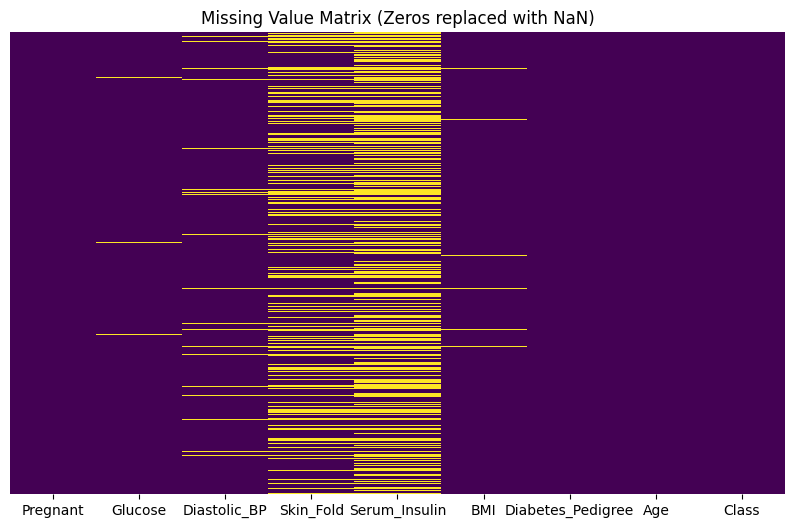

<Figure size 1500x1200 with 0 Axes>

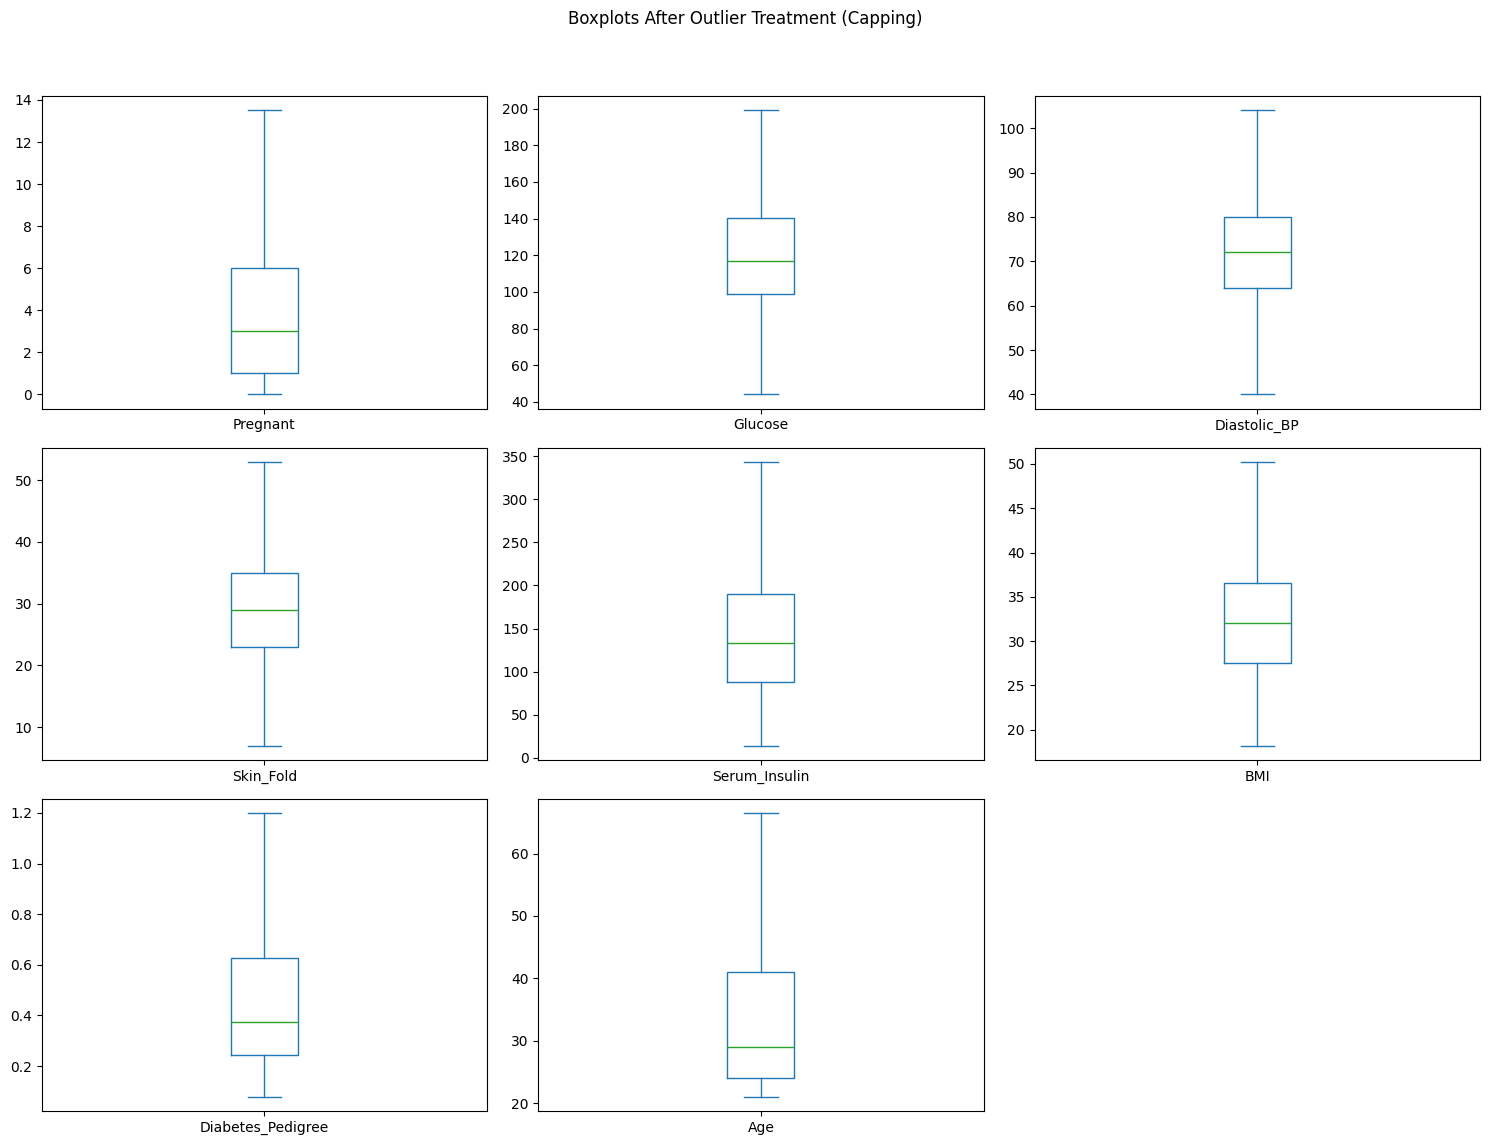

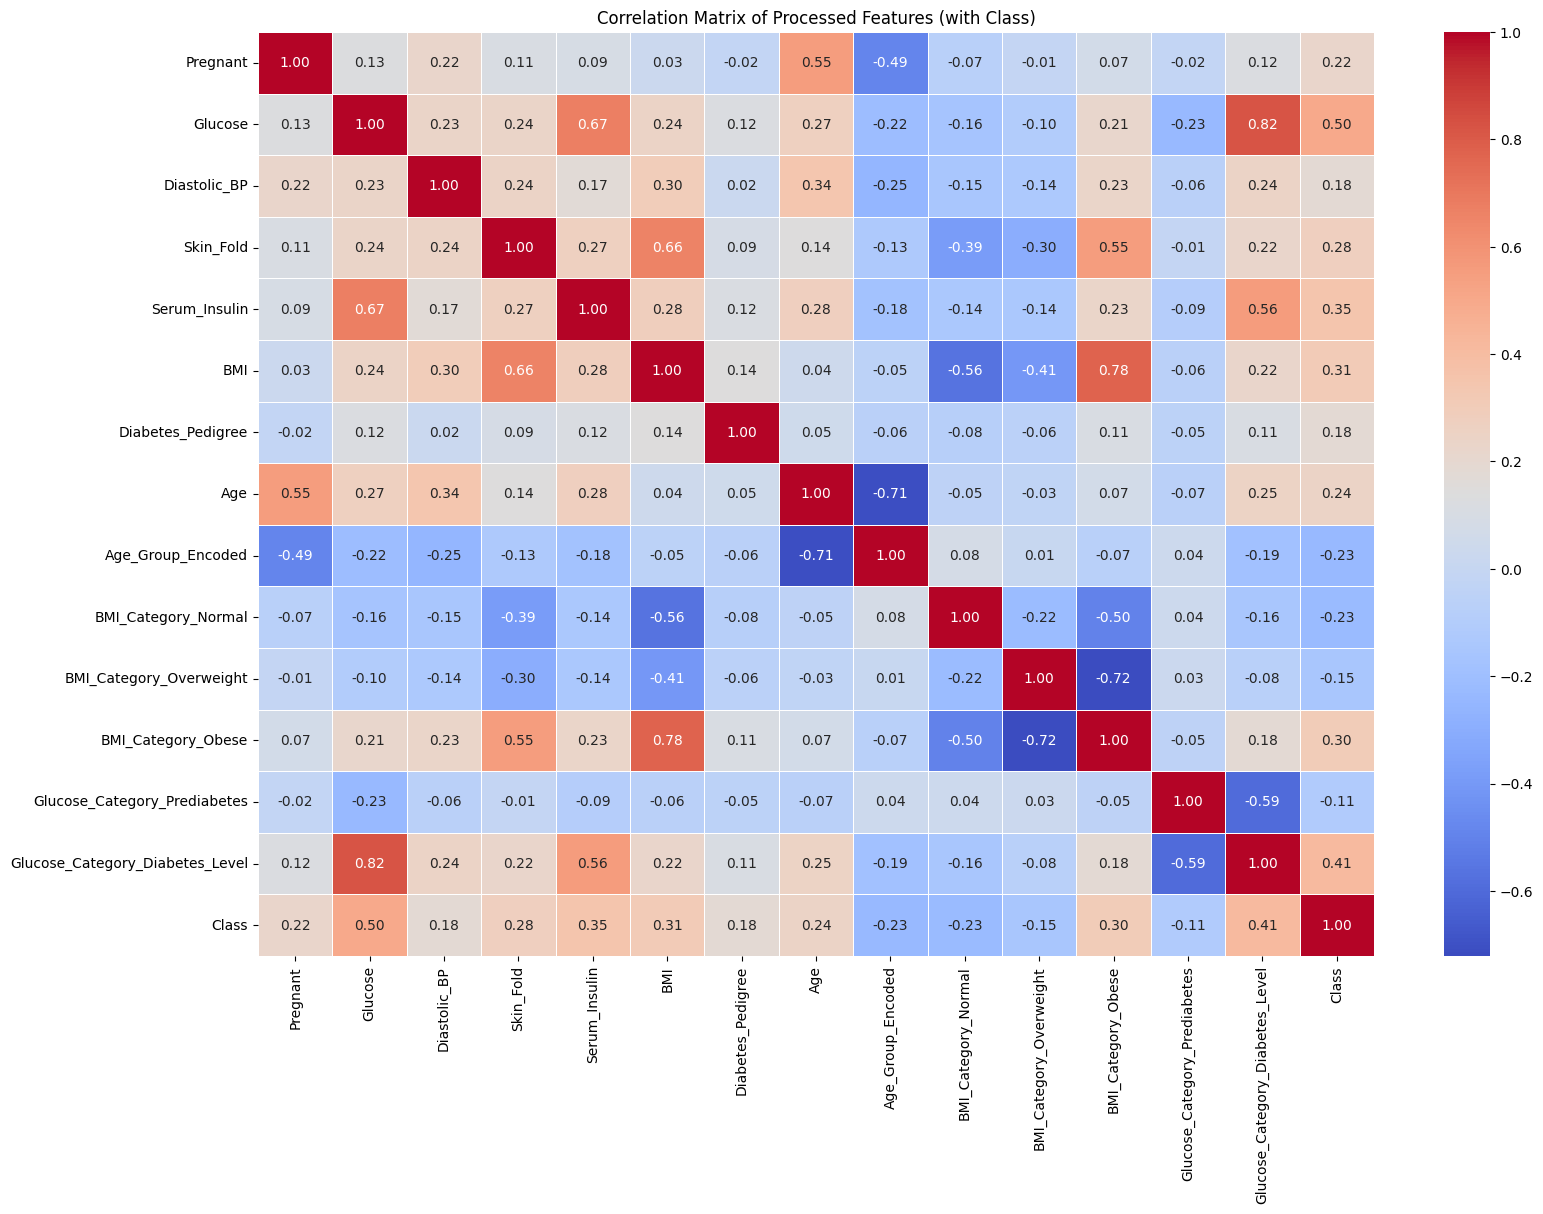

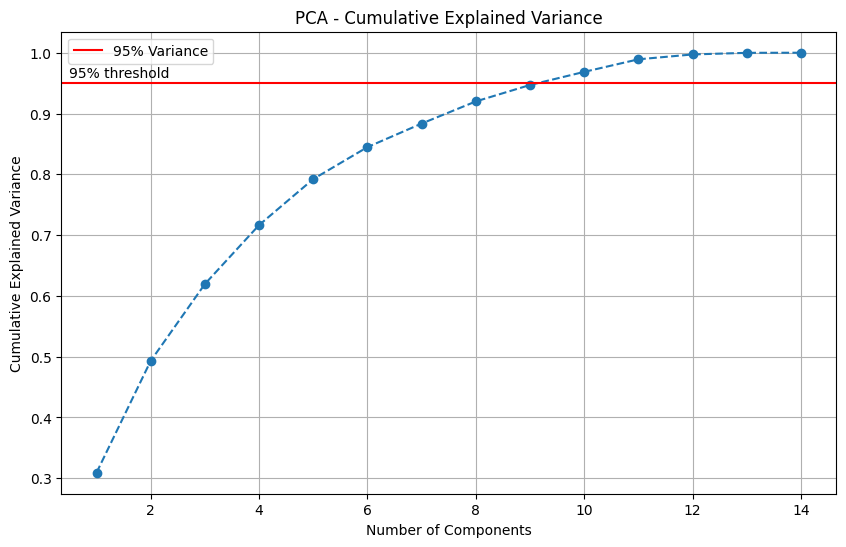

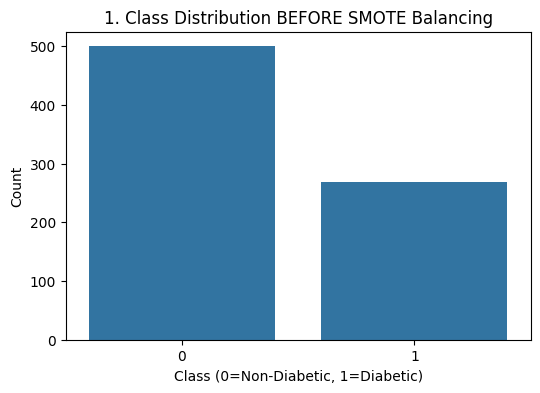

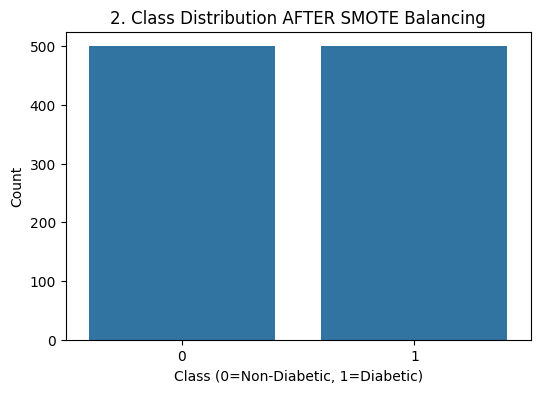

In [25]:
# --- Installation ---
# First, install the 'imbalanced-learn' library for SMOTE
print("Installing 'imbalanced-learn' for SMOTE...")
!pip install imbalanced-learn -q
print("Installation complete.")

# --- Import all required libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
import warnings
import io

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set default figure size
plt.rcParams['figure.figsize'] = (10, 6)


# --- Phase 1: Data Collection & Understanding ---

print("\n--- Phase 1: Data Collection & Understanding ---")

# Task 1: Load the dataset
file_path = "Diabetes Missing Data.csv"
try:
    df = pd.read_csv(file_path)
    print(f"Successfully loaded '{file_path}'.")
except FileNotFoundError:
    print(f"ERROR: The file '{file_path}' was not found.")
    print("Please make sure 'Diabetes Missing Data.csv' is uploaded to your Colab session.")
    # Stop execution if file isn't loaded
    raise

# Task 2: Perform initial data exploration
print("\n--- Initial Data Exploration ---")
print("\nData Head (First 5 Rows):")
print(df.head())

print("\nData Info (Data Types and Non-Null Counts):")
buf = io.StringIO()
df.info(buf=buf)
print(buf.getvalue())

print("\nDescriptive Statistics (Raw Data):")
print(df.describe())

# Task 3: Identify data quality issues
print("\n--- Initial Data Quality Assessment ---")
# Identify biological impossibilities (zeros)
impossible_zero_cols = ['Glucose', 'Diastolic_BP', 'Skin_Fold', 'Serum_Insulin', 'BMI']
print("\nCounts of '0' values in biologically impossible columns (raw data):")
zero_counts = (df[impossible_zero_cols] == 0).sum()
print(zero_counts)


# --- Phase 2: Data Cleaning ---

print("\n--- Phase 2: Data Cleaning ---")

# Task 1: Missing Value Analysis
# 1. Replace impossible zeros with NaN
# (Note: Your file already uses NaN, so this will show 0 replacements, which is correct)
print(f"\nReplacing 0s with NaN in: {impossible_zero_cols}")
df_cleaned = df.copy() # Create a copy to work on
df_cleaned[impossible_zero_cols] = df_cleaned[impossible_zero_cols].replace(0, np.nan)
print("Replacement complete.")

# 2. Document missing value percentages
print("\nMissing Value Percentages:")
missing_percent = (df_cleaned.isnull().sum() / len(df_cleaned)) * 100
missing_percent_sorted = missing_percent[missing_percent > 0].sort_values(ascending=False)
print(missing_percent_sorted)

# 3. Visualize missing patterns
print("\nGenerating missing value visualizations...")
plt.figure(figsize=(10, 6))
sns.heatmap(df_cleaned.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title('Missing Value Matrix (Zeros replaced with NaN)')
plt.savefig("missing_value_matrix.png")
print("Saved 'missing_value_matrix.png'")

# Task 2: Imputation Strategy
print("\nApplying KNN Imputation (n_neighbors=5)...")
# Separate features (X) and target (y)
X = df_cleaned.drop('Class', axis=1)
y = df_cleaned['Class']

# Initialize KNNImputer
imputer = KNNImputer(n_neighbors=5)

# Fit and transform the features
X_imputed_array = imputer.fit_transform(X)
X_imputed = pd.DataFrame(X_imputed_array, columns=X.columns)

print("Imputation complete. Checking for remaining null values:")
print(f"Total null values: {X_imputed.isnull().sum().sum()}")

# Task 3: Outlier Detection & Treatment
print("\nHandling outliers using IQR capping (1.5 * IQR)...")
X_capped = X_imputed.copy()
numeric_cols = X_capped.columns.tolist() # Get column names as a list

for col in numeric_cols:
    Q1 = X_capped[col].quantile(0.25)
    Q3 = X_capped[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Count outliers
    outliers_count = ((X_capped[col] < lower_bound) | (X_capped[col] > upper_bound)).sum()
    if outliers_count > 0:
        print(f"Column '{col}': Found {outliers_count} outliers. Capping them.")

    # Apply capping (Winsorizing)
    X_capped[col] = np.clip(X_capped[col], lower_bound, upper_bound)

# Visualize boxplots after outlier treatment
print("\nGenerating boxplots after outlier treatment...")
try:
    plt.figure(figsize=(15, 12)) # Create a new figure
    X_capped[numeric_cols].plot(kind='box', subplots=True, layout=(3, 3), figsize=(15, 12), sharex=False, sharey=False)
    plt.suptitle('Boxplots After Outlier Treatment (Capping)')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig("boxplots_after_outlier_treatment.png")
    print("Saved 'boxplots_after_outlier_treatment.png'.")
except Exception as e:
    print(f"Error generating outlier boxplots: {e}")



# --- Phase 3: Data Transformation ---

print("\n--- Phase 3: Data Transformation ---")

# Task 1: Feature Engineering
print("\nCreating new categorical features...")
df_transformed = X_capped.copy()

# Create Age Groups
age_bins = [20, 30, 45, 60, 85]
age_labels = ['Young', 'Middle-Aged', 'Senior', 'Elderly']
df_transformed['Age_Group'] = pd.cut(df_transformed['Age'], bins=age_bins, labels=age_labels, right=False)

# Create BMI Categories
bmi_bins = [0, 18.5, 25, 30, 70]
bmi_labels = ['Underweight', 'Normal', 'Overweight', 'Obese']
df_transformed['BMI_Category'] = pd.cut(df_transformed['BMI'], bins=bmi_bins, labels=bmi_labels, right=False)

# Create Glucose Level Categories
glucose_bins = [0, 100, 126, 250]
glucose_labels = ['Normal', 'Prediabetes', 'Diabetes_Level']
df_transformed['Glucose_Category'] = pd.cut(df_transformed['Glucose'], bins=glucose_bins, labels=glucose_labels, right=False)

print("Created categorical features: 'Age_Group', 'BMI_Category', 'Glucose_Category'.")

# Task 2: Encoding
print("\nEncoding new categorical features...")
# 'Age_Group' (Ordinal)
le = LabelEncoder()
# Handle potential NaN in 'Age_Group' by converting to string first
df_transformed['Age_Group'] = df_transformed['Age_Group'].astype(str)
df_transformed['Age_Group_Encoded'] = le.fit_transform(df_transformed['Age_Group'])
df_transformed = df_transformed.drop('Age_Group', axis=1)

# 'BMI_Category' & 'Glucose_Category' (Nominal)
df_transformed = pd.get_dummies(df_transformed, columns=['BMI_Category', 'Glucose_Category'], drop_first=True)
print("Encoding complete.")


# Task 3: Scaling
print("\nApplying StandardScaler...")
numeric_cols_to_scale = ['Pregnant', 'Glucose', 'Diastolic_BP', 'Skin_Fold', 'Serum_Insulin', 'BMI', 'Diabetes_Pedigree', 'Age']

scaler_std = StandardScaler()
X_scaled = df_transformed.copy()
X_scaled[numeric_cols_to_scale] = scaler_std.fit_transform(X_scaled[numeric_cols_to_scale])

print("StandardScaler applied to numeric features.")



# --- Phase 4: Data Reduction ---

print("\n--- Phase 4: Data Reduction ---")

# Task 1: Feature Selection
print("\nGenerating feature correlation heatmap...")
temp_df_for_corr = X_scaled.copy()
temp_df_for_corr['Class'] = y.values # Add original target back
plt.figure(figsize=(18, 12))
sns.heatmap(temp_df_for_corr.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix of Processed Features (with Class)")
plt.savefig("feature_correlation_matrix.png")
print("Saved 'feature_correlation_matrix.png'.")

# Apply SelectKBest with mutual information
print("\nRunning SelectKBest (k=5) with mutual_info_classif...")
# We need non-negative data for mutual_info_classif. Let's create a temporary min-max scaled version.
scaler_minmax = MinMaxScaler()
X_minmax_temp = df_transformed.copy()
X_minmax_temp[numeric_cols_to_scale] = scaler_minmax.fit_transform(X_minmax_temp[numeric_cols_to_scale])
X_minmax_safe = X_minmax_temp.apply(pd.to_numeric, errors='coerce').fillna(0)
y_safe = y.fillna(0) # Ensure y is clean

selector = SelectKBest(mutual_info_classif, k=5)
selector.fit(X_minmax_safe, y_safe)
selected_features = X_minmax_safe.columns[selector.get_support()]
print(f"Top 5 features selected by SelectKBest: {list(selected_features)}")

# Task 2: Dimensionality Reduction (PCA)
print("\nPerforming PCA to visualize explained variance...")
# Use the StandardScaler-scaled data
X_std_scaled_safe = X_scaled.apply(pd.to_numeric, errors='coerce').fillna(0)

pca = PCA()
pca.fit(X_std_scaled_safe)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot cumulative variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('PCA - Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.axhline(y=0.95, color='r', linestyle='-', label='95% Variance')
plt.text(0.5, 0.96, '95% threshold')
plt.legend()
plt.savefig("pca_explained_variance.png")
print("Saved 'pca_explained_variance.png'.")

# Determine optimal components (e.g., for 95% variance)
n_components_95 = np.where(cumulative_variance >= 0.95)[0][0] + 1
print(f"Optimal number of components to explain 95% variance: {n_components_95}")



# --- Phase 5: Data Imbalance Handling (Crucial Visual Update Here) ---

print("\n--- Phase 5: Data Imbalance Handling ---")

# Task 1: Class Distribution Analysis & Visualization (BEFORE SMOTE)
print("\nAnalyzing target class distribution (BEFORE SMOTE)...")
class_distribution = y_safe.value_counts()
print(f"Class Distribution BEFORE SMOTE:\n{class_distribution}")

plt.figure(figsize=(6, 4))
sns.countplot(x=y_safe)
plt.title('1. Class Distribution BEFORE SMOTE Balancing')
plt.ylabel('Count')
plt.xlabel('Class (0=Non-Diabetic, 1=Diabetic)')
plt.savefig("1_class_distribution_before_smote.png")
print("Saved '1_class_distribution_before_smote.png'.")


# Task 2: Balancing Techniques (SMOTE)
print("\nApplying SMOTE to balance the dataset...")
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_std_scaled_safe, y_safe)

print(f"Resampled shape: {X_resampled.shape}, {y_resampled.shape}")
print("\nNew Class Distribution (Post-SMOTE):")
print(pd.Series(y_resampled).value_counts())

# Task 2 (Cont.): Visualization (AFTER SMOTE)
plt.figure(figsize=(6, 4))
sns.countplot(x=y_resampled)
plt.title('2. Class Distribution AFTER SMOTE Balancing')
plt.ylabel('Count')
plt.xlabel('Class (0=Non-Diabetic, 1=Diabetic)')
plt.savefig("2_class_distribution_after_smote.png")
print("Saved '2_class_distribution_after_smote.png'.")








print("---------------------------------------------------------------")
print("\n\nPROJECT PHASES COMPLETE.")

In [26]:
# Assign X_std_scaled_safe to X_to_balance for consistency
X_to_balance = X_std_scaled_safe
y_to_balance = y_safe

print(f"Shape of X_to_balance: {X_to_balance.shape}")
print(f"Shape of y_to_balance: {y_to_balance.shape}")

Shape of X_to_balance: (768, 14)
Shape of y_to_balance: (768,)


In [27]:


print("\n--- Generating Final Deliverables ---")

# 1. Final Clean Dataset
final_X_df = pd.DataFrame(X_resampled, columns=X_std_scaled_safe.columns)
final_y_series = pd.Series(y_resampled, name='Class')
final_dataset = pd.concat([final_X_df, final_y_series], axis=1)

final_dataset.to_csv("diabetes_final_processed_dataset.csv", index=False)
print("Saved 'diabetes_final_processed_dataset.csv'.")
print(f"File 'diabetes_final_processed_dataset.csv' created. This is your final dataset.")

print("\n\nPROJECT PHASES COMPLETE. Please run the Performance Comparison script next.")


# --- Submission Requirements ---

print("\n--- Generating Final Deliverables ---")

# 1. Final Clean Dataset
print("\nSaving final processed and balanced dataset...")
final_X_df = pd.DataFrame(X_resampled, columns=X_to_balance.columns)
final_y_series = pd.Series(y_resampled, name='Class')
final_dataset = pd.concat([final_X_df, final_y_series], axis=1)

final_dataset.to_csv("diabetes_final_processed_dataset.csv", index=False)
print("Saved 'diabetes_final_processed_dataset.csv'.")
print(f"File 'diabetes_final_processed_dataset.csv' created. This is your final dataset.")


--- Generating Final Deliverables ---
Saved 'diabetes_final_processed_dataset.csv'.
File 'diabetes_final_processed_dataset.csv' created. This is your final dataset.


PROJECT PHASES COMPLETE. Please run the Performance Comparison script next.

--- Generating Final Deliverables ---

Saving final processed and balanced dataset...
Saved 'diabetes_final_processed_dataset.csv'.
File 'diabetes_final_processed_dataset.csv' created. This is your final dataset.


--- Step 1: Loading Data and Preparing Baselines ---
Successfully loaded the fully processed and balanced data.

--- Step 2: Training and Comparing Models ---

-----------------------------------------------------
Baseline Model 1: Raw (Imputed Only) Performance
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.77      0.85      0.81       150
           1       0.65      0.53      0.59        81

    accuracy                           0.74       231
   macro avg       0.71      0.69      0.70       231
weighted avg       0.73      0.74      0.73       231


-----------------------------------------------------
Final Model 2: Fully Processed (SMOTEd) Performance
-----------------------------------------------------
              precision    recall  f1-score   support

           0       0.76      0.72      0.74       149
           1       0.74      0.77      0.76       151

    accuracy                   

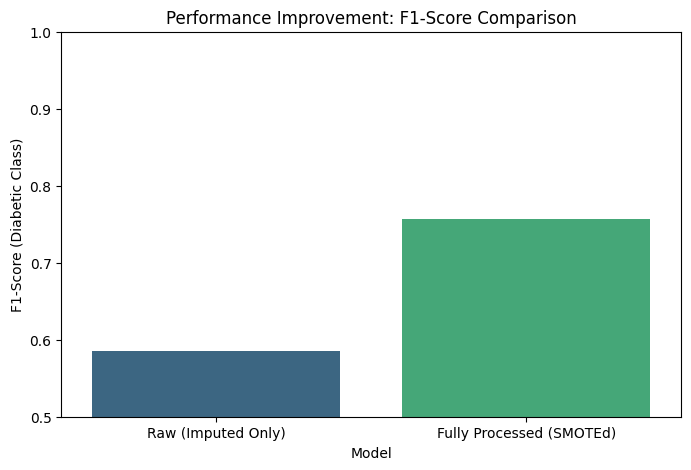

In [28]:
# --- Imports for Modeling and Comparison ---
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, f1_score
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')

print("--- Step 1: Loading Data and Preparing Baselines ---")

# 1. Load Original Data
df_original = pd.read_csv("Diabetes Missing Data.csv")
impossible_zero_cols = ['Glucose', 'Diastolic_BP', 'Skin_Fold', 'Serum_Insulin', 'BMI']
df_imputed = df_original.copy()
df_imputed[impossible_zero_cols] = df_imputed[impossible_zero_cols].replace(0, np.nan)

X_orig = df_imputed.drop('Class', axis=1)
y_orig = df_imputed['Class']

# Apply Imputation (only minimal processing)
imputer = KNNImputer(n_neighbors=5)
X_imputed_array = imputer.fit_transform(X_orig)
X_raw_imputed = pd.DataFrame(X_imputed_array, columns=X_orig.columns)


# 2. Load Final Processed Data (The one we saved as CSV)
# Ensure the previous cell (A5_sOu91u1qa) has been run to create this file
try:
    df_final = pd.read_csv("diabetes_final_processed_dataset.csv")
    X_processed = df_final.drop('Class', axis=1)
    y_processed = df_final['Class']
    print("Successfully loaded the fully processed and balanced data.")
except FileNotFoundError:
    print("Error: 'diabetes_final_processed_dataset.csv' not found. Ensure the main script ran completely.")
    # Reraise the error if the file is still not found
    raise

print("\n--- Step 2: Training and Comparing Models ---")

# --- Model 1: Raw (Imputed Only) Baseline ---
# Data: X_raw_imputed (Imputed, unscaled, imbalanced, no feature engineering)
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
    X_raw_imputed, y_orig, test_size=0.3, random_state=42, stratify=y_orig
)

# Standardize data for Logistic Regression
scaler_raw = StandardScaler()
X_train_raw_scaled = scaler_raw.fit_transform(X_train_raw)
X_test_raw_scaled = scaler_raw.transform(X_test_raw)

model_raw = LogisticRegression(random_state=42, solver='liblinear')
model_raw.fit(X_train_raw_scaled, y_train_raw)
y_pred_raw = model_raw.predict(X_test_raw_scaled)

print("\n-----------------------------------------------------")
print("Baseline Model 1: Raw (Imputed Only) Performance")
print("-----------------------------------------------------")
print(classification_report(y_test_raw, y_pred_raw))


# --- Model 2: Fully Processed (Scaled, Engineered, SMOTEd) Final Data ---
# Data: X_processed (Scaled, engineered, BALANCED)
# Note: This data is already SMOTEd, so we split it 70/30 (no need for stratify as it's balanced)
X_train_proc, X_test_proc, y_train_proc, y_test_proc = train_test_split(
    X_processed, y_processed, test_size=0.3, random_state=42
)

# No scaling needed as it was done in the preprocessing script
model_proc = LogisticRegression(random_state=42, solver='liblinear')
model_proc.fit(X_train_proc, y_train_proc)
y_pred_proc = model_proc.predict(X_test_proc)

print("\n-----------------------------------------------------")
print("Final Model 2: Fully Processed (SMOTEd) Performance")
print("-----------------------------------------------------")
print(classification_report(y_test_proc, y_pred_proc))

# --- Final Comparison Metrics ---
f1_raw = f1_score(y_test_raw, y_pred_raw, pos_label=1)
f1_proc = f1_score(y_test_proc, y_pred_proc, pos_label=1)

print("\n--- Summary Comparison (F1-Score for Diabetic Class) ---")
print(f"Raw (Imputed Only) F1-Score: {f1_raw:.4f}")
print(f"Fully Processed (SMOTEd) F1-Score: {f1_proc:.4f}")

# Generate simple bar chart comparison
comparison_df = pd.DataFrame({
    'Model': ['Raw (Imputed Only)', 'Fully Processed (SMOTEd)'],
    'F1_Score': [f1_raw, f1_proc]
})

plt.figure(figsize=(8, 5))
sns.barplot(x='Model', y='F1_Score', data=comparison_df, palette='viridis')
plt.title('Performance Improvement: F1-Score Comparison')
plt.ylabel('F1-Score (Diabetic Class)')
plt.ylim(0.5, 1.0)
plt.savefig("performance_comparison_f1.png")
print("\nSaved 'performance_comparison_f1.png'.")